In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip './drive/My Drive/dataset/srdb.zip'

#Dataset

In [0]:
import torch
from torch.utils.data.dataset import Dataset

import torchvision
import torchvision.transforms as transforms

import os

from PIL import Image

class read_dataset(Dataset):
    def __init__(self,data_dir):
        self.data_list=[data_dir+file_name for file_name in os.listdir(data_dir)]
        self.random_crop=transforms.Compose([transforms.RandomCrop((64,64))])
        self.make_lowscale=transforms.Compose([transforms.Resize((32,32))])
        self.totensor=transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,index):
        original_img=Image.open(self.data_list[index])
        
        original_img=self.random_crop(original_img)
        lowscale_img=self.make_lowscale(original_img)
        
        original_img=self.totensor(original_img)
        lowscale_img=self.totensor(lowscale_img)
                
        return original_img,lowscale_img

#Model

In [0]:
import torch.nn as nn

class SRNet(nn.Module):
    def __init__(self):
        super(SRNet,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,64,9,1,4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,32,1,1,0),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(32,3,4,2,1),
            nn.Tanh()
        )

    def forward(self,x):
        out=self.layer(x)
        return out

#Training

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader

# 디바이스 식별

device='cuda' if torch.cuda.is_available() else 'cpu'

if __name__=='__main__':
    batch_size=64
    
    # 트레이닝 데이터 로드

    train_data=read_dataset('./sr/')
    train_set=DataLoader(train_data,batch_size,True)

    # 트레이닝

    learning_rate=0.0002
    training_epochs=5001

    net=SRNet().to(device)

    criterion=nn.MSELoss()
    
    optimizer=optim.Adam(net.parameters(),learning_rate)

    print('Learning started. It takes sometime.')

    for epoch in range(1,training_epochs):
        for original,lowscale in train_set:
            original=original.to(device)
            lowscale=lowscale.to(device)
            
            batch_size=original.size(0)

            optimizer.zero_grad()

            hypothesis=net(lowscale)
            cost=criterion(hypothesis,original)

            cost.backward()
            optimizer.step()
            
        print('epoch',epoch,'is over')
            
        # 트레이닝 데이터 저장
        
        if epoch%1000==0:
            torch.save(net.state_dict(),'./model_epoch_%d.pth'%(epoch))
    
    print('Learning Finished!')

#Test

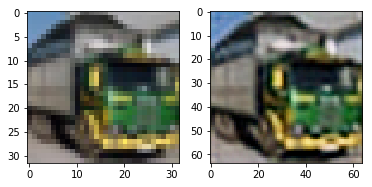

In [6]:
from matplotlib import pyplot as plt

transform=transforms.Compose([transforms.ToTensor()])

if __name__=='__main__':
    net=SRNet()

    # 네트워크 데이터 로드

    load_net='./model_epoch_5000.pth'
    net.load_state_dict(torch.load(load_net))

    with torch.no_grad():
        test_img=Image.open('./test.png')
        h,w=test_img.size
        test_img=test_img.crop((0,0,int(h/32)*32,int(w/32)*32))
        z=transform(test_img)
        fake_image=net(z.unsqueeze(0))
                        
        fig=plt.figure()
        ax1=fig.add_subplot(1,2,1)
        ax2=fig.add_subplot(1,2,2)
        
        ax1.imshow(test_img)
        ax2.imshow(fake_image.squeeze().permute(1,2,0).numpy().clip(0,1))
        
        plt.show()
        
        torchvision.utils.save_image(fake_image,'test_to_sr.png')